### ADS Tuner for HPO

A first example, using Breast Cancer Dataset, and:
* ADSTuner for HPO optimization
* MLFlow to track experiments
* XGB

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

import mlflow

In [3]:
# load the dataset

cancer = load_breast_cancer()

# load in Pandas DataFrame
df = pd.DataFrame(
    np.c_[cancer["data"], cancer["target"]],
    columns=np.append(cancer["feature_names"], ["target"]),
)

In [4]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [5]:
TARGET = "target"

# let's choose some of the column
FEATURES = ["mean radius", "mean concavity", "mean symmetry", "mean fractal dimension"]

X = df[FEATURES].values
y = df[TARGET].values

In [6]:
# train, test split
# we will be using CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
print("# of samples in train set", X_train.shape[0])
print("# of samples in test set", X_test.shape[0])

# of samples in train set 455
# of samples in test set 114


### Using Random Forest we're developing a classifier to predict target
we will be using ADSTuner to get the best value for max_depth

In [34]:
clf = XGBClassifier(random_state=0)

tuner = ADSTuner(clf, cv=5)

# execution by default is async
tuner.tune(X_train, y_train, exit_criterion=[TimeBudget(120)])

[15:42:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:42:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Process Process-2:
Traceback (most recent call last):
  File "/home/datascience/conda/generalml_p37_gpu_v1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/datascience/conda/generalml_p37_gpu_v1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/datascience/conda/generalml_p37_gpu_v1/lib/python3.7/site-packages/ads/hpo/search_cv.py", line 1262, in optimizer
    study.optimize(objective_func, **kwargs)
  File "/home/datascience/conda/generalml_p37_gpu_v1/lib/python3.7/site-packages/optuna/study/study.py", line 409, in optimize
    show_progress_bar=show_progress_bar,
  File "/home/datascience/conda/generalml_p37_gpu_v1/lib/python3.7/site-packages/optuna/study/_optimize.py", line 76, in _optimize
    progress_bar=progress_bar,
  File "/home/datascience/conda/generalml_p37_gpu_v1/lib/python3.7/site-packages/optuna/study/_optimize.py", line 163, in _optimize_sequential
    tri

In [36]:
# this is a Pandas DataFrame
tuner.trials.head(20)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_n_estimators,params_subsample,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
0,0,0.896703,2022-02-22 15:42:04.928097,2022-02-22 15:42:26.709586,0 days 00:00:21.781489,0.727773,0.308248,2,69,0.655070,...,mean accuracy,0.868132,0.879121,0.945055,0.868132,0.923077,0.061482,0.000490,0.031544,COMPLETE
1,1,0.901099,2022-02-22 15:42:26.728831,2022-02-22 15:42:36.828191,0 days 00:00:10.099360,0.726662,0.349787,1,50,0.534476,...,mean accuracy,0.868132,0.890110,0.934066,0.912088,0.901099,0.017594,0.001597,0.021978,COMPLETE
2,2,0.896703,2022-02-22 15:42:36.845163,2022-02-22 15:43:23.008291,0 days 00:00:46.163128,0.654510,0.388539,1,235,0.901585,...,mean accuracy,0.879121,0.879121,0.945055,0.890110,0.890110,0.095291,0.000440,0.024670,COMPLETE
3,3,NaN,2022-02-22 15:43:23.022073,NaT,NaT,0.794523,0.377508,1,180,0.807708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RUNNING


In [37]:
tuner.best_score

0.9010989010989011

In [38]:
# we have not specified a strategy. If we want to limit the parameters we're changing... we need a strategy
tuner.best_params

{'colsample_bytree': 0.7266615284359348,
 'learning_rate': 0.3497865284853692,
 'max_depth': 1,
 'n_estimators': 50,
 'subsample': 0.534475598133012}

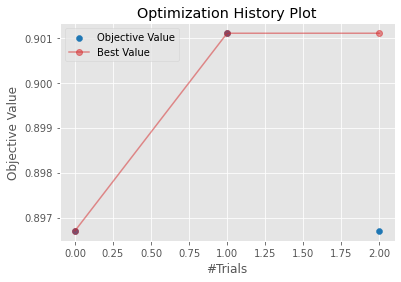

In [39]:
# il plot è aggiornato in maniera asincrona
tuner.plot_best_scores()

In [40]:
tuner.search_space()

{'colsample_bytree': UniformDistribution(low=0.6, high=0.8),
 'learning_rate': LogUniformDistribution(low=0.3, high=0.4),
 'max_depth': IntUniformDistribution(low=1, high=5, step=1),
 'n_estimators': IntUniformDistribution(low=50, high=250, step=1),
 'subsample': UniformDistribution(low=0.5, high=1)}

In [41]:
tuner.scoring_name

'mean accuracy'